In [12]:
from shapely.geometry import Polygon
from pyproj import Geod
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
import math
import scipy
import chaosmagpy as cp
from matplotlib.path import Path
import chaosmagpy as cp
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

In [13]:
def dx(ym, xm, f):
    dxm = np.abs(xm[0, 1] - xm[0, 0])
    der = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dxm)
    der[:, 0] = (f[:, 1] - f[:, -2]) / (2 * dxm)
    der[:, -1] = der[:, 0]
    return der

def dy(ym, xm, f):
    dym = np.abs(ym[1, 0] - ym[0, 0])
    der = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2 * dym)
    der[0, :] = (f[1, :] - f[0, :]) / (dym)
    der[1, :] = (f[-1, :] - f[-2, :]) / (dym)
    return der

def ddy(ym, xm, f):
    dym = np.abs(ym[1, 0] - ym[0, 0])
    der = (np.roll(f, 1, axis=0) - 2 * f + np.roll(f, -1, axis=0)) / (dym ** 2)
    der[0, :] = der[1, :]
    der[-1, :] = der[-2, :]
    return der

def ddx(ym, xm, f):
    dxm = np.abs(xm[0, 1] - xm[0, 0])
    der = (np.roll(f, 1, axis=1) - 2 * f + np.roll(f, -1, axis=1)) / (dxm ** 2)
    der[:, 0] = (f[:, 1] - 2 * f[:, 0] + f[:, -2]) / (dxm ** 2)
    der[:, -1] = der[:, 0]
    return der

def ddxy(ym, xm, f):
    df_dx = dx(ym, xm, f)
    ddf_dxy = dy(ym, xm, df_dx)
    return ddf_dxy

def detH(ddx,ddy):
    derH=(ddx*ddy)
    return derH

def read_gauss_coeffs(filename, target_year, lmax=25):
    """
    已经经过修正的20250703
    Histkalmag格式的文件中读取指定年份的高斯系数，
    输出 gsh 和 hsh 按 (l, m) 顺序排列。
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    years = list(map(float, lines[0].strip().split()))
    if target_year not in years:
        raise ValueError(f"目标年份 {target_year} 不在数据中")
    idx = years.index(target_year)

    coeff_lines = lines[1:len(lines)]
    coeffs = [list(map(float, line.strip().split())) for line in coeff_lines]

    coeffs_at_year = [row[idx] for row in coeffs]
    gsh = []
    hsh = []
    i = 0
    for l in range(1, lmax + 1):
        for m in range(0, l + 1):
            if m == 0:
                gsh.append(coeffs_at_year[i])
                i+=1
                hsh.append(0.0)
            else:
                gsh.append(coeffs_at_year[i])
                i+=1
                hsh.append(coeffs_at_year[i])
                i += 1
    return np.array(gsh), np.array(hsh)

# 计算主磁场
def magnetic_field(gsh,hsh,lmax,r,lats,lons):
    a=6371.2
    pi            = math.pi
    # lats          =  np.linspace(1., 179., num=181)
    # lons          =  np.linspace(-180., 180., num=181)
    lons2d,lats2d = np.meshgrid(lons,lats)
    phi           = lons2d
    cost2d        = np.cos((lats2d)*np.pi/180)
    i             = 0
    br            = np.zeros((cost2d.shape))
    bphi          = np.zeros((cost2d.shape))
    btheta        = np.zeros((cost2d.shape))
    for l in np.arange(1,lmax+1,1):
        for m in np.arange(0,l+1,1):
            g=gsh[i]
            h=hsh[i]
            #calculate schmidt
            if m  == 0:
                schmidt = 1.0
            else:
                schmidt = ((-1.0)**m)*np.sqrt(2.0*math.factorial(l-m)/math.factorial(l+m))
            lagendre     = scipy.special.lpmv(m, l, cost2d)
            lagendre_    = scipy.special.lpmv(m, l-1, cost2d)
            div_lagendre = (l*cost2d*lagendre-(l+m)*lagendre_)/np.sqrt(1-cost2d**2)
            br           = br     + schmidt*(float(l)+1.0)*((a/r)**(l+2))*lagendre*(g*np.cos(float(m)*phi*pi/180.0)
                                                                                    +h*np.sin(float(m)*phi*pi/180.0))
            bphi         = bphi   + schmidt*(m/np.sin((lats2d)*pi/180))*((a/r)**(l+2))*lagendre*(-g*np.sin(float(m)*phi*pi/180.0)
                                                                                                    +h*np.cos(float(m)*phi*pi/180.0))
            btheta       = btheta + schmidt*((a/r)**(l+2))*(div_lagendre)*(g*np.cos(float(m)*phi*pi/180.0)+h*np.sin(float(m)*phi*pi/180.0))
            i+=1
    return br,bphi,btheta,lons2d,lats2d


def mean_F(f,thetam):
    theta_rad = np.deg2rad(thetam)
    sin=np.sin(theta_rad)
    product_sum = np.sum(f[30:151, :] * sin[30:151, :])
    C = np.sum(sin[30:151, :])
    mean=product_sum/C
    return mean

def calculate_integral(B):
    #计算归一化 积分
    phi_range = np.linspace(0, 2 * np.pi, B.shape[1] + 1)  # 经度范围
    theta_range = np.linspace(0, np.pi, B.shape[0] + 1)  # 纬度范围

    integrals = [0, 0]
    theta_min = np.deg2rad(25)
    theta_max = np.deg2rad(155)
    region_boundaries = [
        [(0, 2 * np.pi), (0, theta_min)],
        [(0, 2 * np.pi), (theta_max, np.pi)] ]
    for i, region in enumerate(region_boundaries):
        for j in range(len(phi_range) - 1):
            for k in range(len(theta_range) - 1):
                phi_lower = phi_range[j]
                phi_upper = phi_range[j + 1]
                theta_lower = theta_range[k]
                theta_upper = theta_range[k + 1]
                sin_theta = np.sin((theta_lower + theta_upper) / 2)
                d_phi = phi_upper - phi_lower
                d_theta = theta_upper - theta_lower

                if region[0][0] <= (phi_lower + phi_upper) / 2 <= region[0][1] and region[1][0] <= (theta_lower + theta_upper) / 2 <= region[1][1]:
                    integrals[i] += B[k, j] * sin_theta * d_phi * d_theta
    integral = sum(integrals)
    return integral
#计算Fout
def F_boundary(constant,B,B_t0):
    Fup = calculate_integral(B)
    Fdown = calculate_integral(B_t0)
    F_out = Fup / Fdown
    #F边界
    boundaryF=constant*F_out
    return boundaryF

In [14]:
def F_C_ObO(x, y, fun1,fun2,lev):
    c_fx = plt.contour(x, y, fun1, levels=[lev])
    c_fy = plt.contour(x, y, fun2, levels=[lev])

    Line_dx=[]
    points_dx=[]
    paths = c_fx.get_paths()
    polygons = paths[0].to_polygons()
    for i, poly in enumerate(polygons):
        verts = poly
        if abs(verts[-1,0]-verts[-2,0])>10 or abs(verts[-1,1]-verts[-2,1])>10:
            zz=2
        else:
            zz=1
        points_dx.extend(verts)
        FxLine=[]
        for v in range(len(verts) - zz):
            xa,ya=verts[v]
            xb,yb=verts[v+1]
            xlist= np.array([xa,xb])
            ylist= np.array([ya,yb])
            # 如果两个点太近（避免 polyfit 崩溃）
            if np.isclose(xa, xb) and np.isclose(ya, yb):
                continue  # 跳过这对点
            try:
                k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
            except np.linalg.LinAlgError:
                print(f"警告：polyfit 在点 ({xa}, {ya}) - ({xb}, {yb}) 拟合失败，已跳过。")
                continue
    
            k, b = np.polyfit(xlist, ylist, deg=1)
            FxLine.append([k, b, xa, xb, ya, yb])
    
        Line_dx.append(np.array(FxLine))
    
    Line_dy = []
    points_dy=[]
    paths = c_fy.get_paths()
    polygons = paths[0].to_polygons()
    for i, poly in enumerate(polygons):
        verts = poly

        if abs(verts[-1,0]-verts[-2,0])>10 or abs(verts[-1,1]-verts[-2,1])>10:
            zz=2
        else:
            zz=1
        points_dy.extend(verts)
        FyLine=[]
        for v in range(len(verts) - zz):
            xa,ya=verts[v]
            xb,yb=verts[v+1]
            xlist= np.array([xa,xb])
            ylist= np.array([ya,yb])
            # 如果两个点太近（避免 polyfit 崩溃）
            if np.isclose(xa, xb) and np.isclose(ya, yb):
                continue  # 跳过这对点
            try:
                k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
            except np.linalg.LinAlgError:
                print(f"警告：polyfit 在点 ({xa}, {ya}) - ({xb}, {yb}) 拟合失败，已跳过。")
                continue
    
            k, b = np.polyfit(xlist, ylist, deg=1)
            FyLine.append([k, b, xa, xb, ya, yb])
        Line_dy.append(np.array(FyLine))
    
    x_cross=[]
    y_cross=[]
    for n in range(0, len(Line_dx)):
        Fx = Line_dx[n]
        for m in range(0, len(Line_dy)):
            Fy = Line_dy[m]
            for p in range(0, len(Fx[:,0])):
                k1,b1,x1,x2,y1,y2=Fx[p, :]
                for q in range(0, len(Fy[:,0])):
                    k2,b2,x3,x4,y3,y4=Fy[q, :]
                    x_c= (b2 - b1) / (k1 - k2)
                    if x_c is not None:
                        # 判断x_c是否在两段线段的x范围内
                        in_range_1 = (min(x1, x2) <= x_c <= max(x1, x2))
                        in_range_2 = (min(x3, x4) <= x_c <= max(x3, x4))
                        if in_range_1 and in_range_2:
                            y_c = k1 * x_c + b1
                            if y_c is not None:
                                # 判断x_c是否在两段线段的x范围内
                                in_range_3 = (min(y1, y2) <= y_c <= max(y1, y2))
                                in_range_4 = (min(y3, y4) <= y_c <= max(y3, y4))
                                if in_range_3 and in_range_4:
                                    x_cross.append(x_c)
                                    y_cross.append(y_c)
    
    x_cross = np.array(x_cross)
    y_cross = np.array(y_cross)
    
    # 创建布尔掩码，筛选 x 在 [5, 175] 范围内的点
    mask = (y_cross >= 5) & (y_cross <= 175)
    x_cross = x_cross[mask]
    y_cross = y_cross[mask]
    return x_cross,y_cross


def detH_saddle(DETH, thetam, phim, crossingsX,crossingsY):

    lat_grid = thetam[:, 0]
    lon_grid = phim[0, :]

    interp_func = scipy.interpolate.RegularGridInterpolator((lat_grid, lon_grid), DETH,
                                                            bounds_error=False,
                                                            fill_value=np.nan)
    cross = np.column_stack((crossingsX, crossingsY))
    cross = np.array(cross)
    points_for_interp = cross[:, [1, 0]]
    # 插值
    values = interp_func(points_for_interp)


    # 分类
    pos_mask = values > 0
    neg_mask = values <= 0

    pos_points = points_for_interp[pos_mask]
    neg_points = points_for_interp[neg_mask]

    return pos_points, neg_points

In [15]:
# 计算主磁场
def magnetic_point(gsh, hsh, lmax, r, lats, lons):
    a = 6371.2
    pi = math.pi
    # lats          =  np.linspace(1., 179., num=181)
    # lons          =  np.linspace(-180., 180., num=181)
    lons2d, lats2d = lons, lats
    phi = lons2d
    cost2d = np.cos((lats2d) * np.pi / 180)
    i = 0
    br = np.zeros(cost2d.shape)
    bphi = np.zeros(cost2d.shape)
    btheta = np.zeros(cost2d.shape)
    for l in np.arange(1, lmax + 1, 1):
        for m in np.arange(0, l + 1, 1):
            g = gsh[i]
            h = hsh[i]
            # calculate schmidt
            if m == 0:
                schmidt = 1.0
            else:
                schmidt = ((-1.0) ** m) * np.sqrt(2.0 * math.factorial(l - m) / math.factorial(l + m))
            lagendre = scipy.special.lpmv(m, l, cost2d)
            lagendre_ = scipy.special.lpmv(m, l - 1, cost2d)
            div_lagendre = (l * cost2d * lagendre - (l + m) * lagendre_) / np.sqrt(1 - cost2d ** 2)
            br = br + schmidt * (float(l) + 1.0) * ((a / r) ** (l + 2)) * lagendre * (
                        g * np.cos(float(m) * phi * pi / 180.0)
                        + h * np.sin(float(m) * phi * pi / 180.0))
            bphi = bphi + schmidt * (m / np.sin((lats2d) * pi / 180)) * ((a / r) ** (l + 2)) * lagendre * (
                        -g * np.sin(float(m) * phi * pi / 180.0)
                        + h * np.cos(float(m) * phi * pi / 180.0))
            btheta = btheta + schmidt * ((a / r) ** (l + 2)) * (div_lagendre) * (
                        g * np.cos(float(m) * phi * pi / 180.0) + h * np.sin(float(m) * phi * pi / 180.0))
            i += 1
    return br, bphi, btheta, lons2d, lats2d
def magnetic_point(gsh, hsh, lmax, r, y, x):
    fi=[]
    for i in range(0,len(y)):
        br,bphi,btheta,_,_=magnetic_field(gsh, hsh, lmax, radius, y[i], x[i])
        fff=np.sqrt(br**2 + bphi**2 + btheta**2)/1000
        fi.append(fff)
    return np.array(fi).squeeze()


In [16]:
radius = 6371.
theta = np.linspace(1., 179., num=181)  # colatitude in degrees
phi = np.linspace(0., 360., num=361)  # longitude in degrees 改区间需要修改
phim, thetam = np.meshgrid(phi, theta)
radiusm = radius * np.ones(phim.shape)
filepath="D:\Fig\origin data\coeff\HistKalmag.txt"

lmax=20
r=6371
n=1
gsh, hsh = read_gauss_coeffs(filepath, 1950, lmax=lmax)
br,bphi,btheta,lons2d,lats2d=magnetic_field(gsh, hsh, lmax, radius, theta, phi)
F1950=np.sqrt(br**2 + bphi**2 + btheta**2)/1000
Fo1950=calculate_integral(F1950)

<>:6: SyntaxWarning: invalid escape sequence '\F'
<>:6: SyntaxWarning: invalid escape sequence '\F'
C:\Users\yue-y\AppData\Local\Temp\ipykernel_9032\1361913092.py:6: SyntaxWarning: invalid escape sequence '\F'
  filepath="D:\Fig\origin data\coeff\HistKalmag.txt"


<>:7: SyntaxWarning: invalid escape sequence '\F'
<>:7: SyntaxWarning: invalid escape sequence '\F'
C:\Users\yue-y\AppData\Local\Temp\ipykernel_9032\970924163.py:7: SyntaxWarning: invalid escape sequence '\F'
  filepath="D:\Fig\origin data\coeff\HistKalmag.txt"
C:\Users\yue-y\AppData\Local\Temp\ipykernel_9032\1225394214.py:58: RankWarning: Polyfit may be poorly conditioned
  k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
C:\Users\yue-y\AppData\Local\Temp\ipykernel_9032\1225394214.py:63: RankWarning: Polyfit may be poorly conditioned
  k, b = np.polyfit(xlist, ylist, deg=1)


10
1
2
1.0


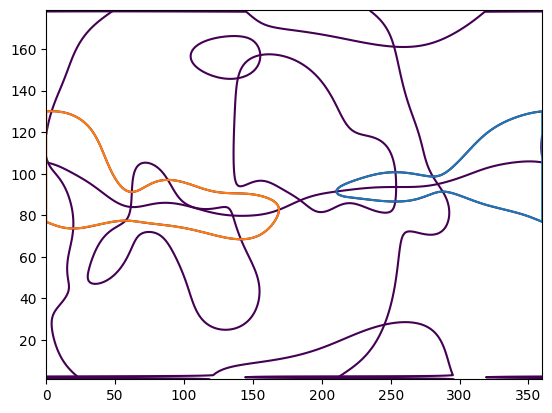

In [17]:
import matplotlib.colors as mcolors
radius = 6371.
theta = np.linspace(1., 179., num=181)  # colatitude in degrees
phi = np.linspace(0., 360., num=361)  # longitude in degrees 改区间需要修改
phim, thetam = np.meshgrid(phi, theta)
radiusm = radius * np.ones(phim.shape)
filepath="D:\Fig\origin data\coeff\HistKalmag.txt"

#%%
cmap="RdGy"# 'PuOr_r'
linecolor="forestgreen"
vmin = 20
vmax = 70

fontweight='bold'
fontname='Arial'
fontsize=14
markersize = 70
SaddleColor="k"
SaddleMarker="o"
ExtremaColor="white"
ExtremaMarker="^"

massmarker_Fs="+"
massmarker="x"
masscolor="forestgreen"
masssize=60
subregionCMcolor='lime'
vmin = 25
vmax = 55

lmax=20
r=6371
n=1
# yr=1735

yr=1740
gsh, hsh = read_gauss_coeffs(filepath, yr, lmax=lmax)
br,bphi,btheta,lons2d,lats2d=magnetic_field(gsh, hsh, lmax, radius, theta, phi)
F=np.sqrt(br**2 + bphi**2 + btheta**2)/1000
Fout = calculate_integral(F)
Fc = 32 * (Fout / Fo1950)

vcenter = Fc  # 想让这个值为白色
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

F_real = F
d_x = dx(thetam, phim, F_real)
d_y = dy(thetam, phim, F_real)
dd_x = ddx(thetam, phim, F_real)
dd_y = ddy(thetam, phim, F_real)

DETH = detH(dd_x, dd_y)
crossingsX1, crossingsY1= F_C_ObO(phi, theta, d_x, d_y,0)
E, S = detH_saddle(DETH, thetam, phim, crossingsX1, crossingsY1)
H_S_lat, H_S_lon=S[:,0],S[:,1]
H_E_lat, H_E_lon=E[:,0],E[:,1]

F_S=magnetic_point(gsh, hsh, lmax, r, H_S_lat, H_S_lon)
F_E=magnetic_point(gsh, hsh, lmax, r, H_E_lat, H_E_lon)
print(len(crossingsX1))



c_fo = plt.contour(phi, theta, F, levels=[Fc])   # get contour
paths = c_fo.get_paths()          # get contour path(all)
polygons1 = paths[0].to_polygons()
area_same_fo=[]
print(len(paths))
print(len(polygons1))

nn=0
zz=0
for poly in polygons1:
    lat_line=poly[:,1]
    lon_line=poly[:,0]
    
    if poly[0,0]==poly[-1,0]==360.0 or poly[0,0]==poly[-1,0]==0.0:
        zz=1+zz
    else:
        nn=nn+1
    plt.plot(poly[:,0], poly[:,1])

Num=nn+(zz/2)
print(Num)

# 假设 Fc 已定义
mask_S = F_S < Fc
mask_E = F_E < Fc

# 筛选出符合条件的点及坐标
F_S_selected = F_S[mask_S]
F_E_selected = F_E[mask_E]

lat_S_selected = H_S_lat[mask_S]
lon_S_selected = H_S_lon[mask_S]

lat_E_selected = H_E_lat[mask_E]
lon_E_selected = H_E_lon[mask_E]

markersize=40
linecolor = 'forestgreen'
camp="RdGy"#"Spectral_r"
# RdGy
import cartopy.crs as ccrs 

import matplotlib.colors as mcolors

F_S_selected=np.array(F_S_selected)

# camp = mcolors.LinearSegmentedColormap.from_list("BlueGray", colors)
# 设定最小值、最大值，以及你想要白色出现的位置（28）
vmin = 20
vmax = 70
vcenter = Fc  # 想让这个值为白色
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)




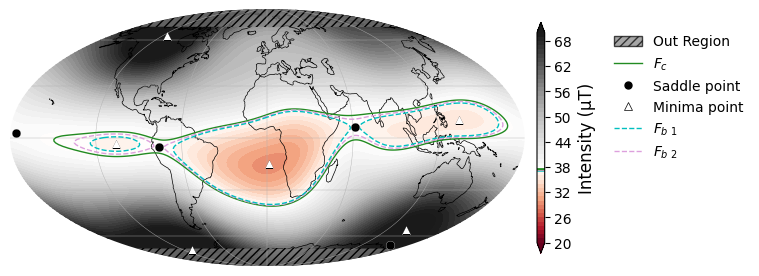

In [20]:
polar_patch = Patch(facecolor='gray', edgecolor='k', hatch='////', label='Out Region', alpha=0.7)
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(1, 1, 1,projection=ccrs.Mollweide())
# ax1.set_global()
ax1.coastlines(linewidth=0.5)
ax1.gridlines(draw_labels=False, linewidth=0.3)
for spine in ax1.spines.values():
    spine.set_visible(False)
    
C = np.linspace(20., 70., 51)
c1 = ax1.contourf(phim,90- thetam, F , levels=C, cmap=camp, transform=ccrs.PlateCarree(),extend="both",norm=norm )
c2 = ax1.contour(phim, 90-thetam, F, levels=[Fc], colors=linecolor,linewidths=1, transform=ccrs.PlateCarree())

ax1.scatter(H_E_lon, 90 - H_E_lat, color=ExtremaColor, marker=ExtremaMarker, s=markersize, transform=ccrs.PlateCarree(), zorder=5,edgecolors="k",linewidths=0.1)
ax1.scatter(H_S_lon, 90 - H_S_lat, color=SaddleColor, marker=SaddleMarker,s=markersize, transform=ccrs.PlateCarree(), zorder=5,edgecolors="white",linewidths=0.2)



color=['plum','c','greenyellow',]
for i in range(0,len(F_S_selected)):
    
    c2 = ax1.contour(phim, 90-thetam,F, levels=[0.999*F_S_selected[i]], colors=color[i],linewidths=1, transform=ccrs.PlateCarree(),linestyles='--')
    

legend_elements1 = [
    polar_patch,
    Line2D([0], [0], color=linecolor, lw=1 , label=r'$F_c$'),
    Line2D([0], [0], marker=SaddleMarker, color=SaddleColor, label='Saddle point', markersize=5, linestyle='None'),
    Line2D([0], [0], color=ExtremaColor, marker=ExtremaMarker,label='Minima point', markersize=6, linestyle='None', markeredgecolor='k',markeredgewidth=0.5),
    # Line2D([0], [0], marker=massmarker, color=masscolor, label='Center of mass in $F_c$', markersize=5, linestyle='None'),
    Line2D([0], [0], color='c', lw=1 , label=r'$F_{b~1}$',linestyle='dashed'),
    Line2D([0], [0], color='plum', lw=1 , label=r'$F_{b~2}$',linestyle='dashed')
]
ax1.legend(
    handles=legend_elements1,
    loc='upper left',              # 图例“对齐方式”
    bbox_to_anchor=(1.15, 0.95),     # 图外右上角，x=1.2表示往右移动，y=1.0表示顶部对齐
    frameon=False)
# ax1.legend(handles=legend_elements1, loc='best')
cbar = fig.colorbar(c1, ax=ax1, orientation='vertical', pad=0.02, aspect=30,shrink=0.5)
cbar.set_label("Intensity (μT)", fontsize=12)
cbar.ax.axhline(Fc, color=linecolor, linewidth=2)
for i, val in enumerate(F_S_selected):
    cbar.ax.axhline(val * 0.999, color=color[i],
                    linewidth=0.5)

# 创建灰色蒙版：纬度 > 30 和 < -30 的区域
lon = np.linspace(-180, 180, 361)

cbar.ax.axvline(Fc, color='goldenrod', linewidth=2)
# cb.ax.text(Fb, 1.05, f'$F_b={Fb:.1f}$', color='goldenrod',ha='center', va='bottom', transform=cb.ax.transData, fontsize=9)


# 北极区
lat1 = 70
poly1 = Polygon(list(zip(lon, [lat1]*len(lon))) + list(zip(lon[::-1], [90]*len(lon))))
# 南极区
lat2 = -70
poly2 = Polygon(list(zip(lon, [lat2]*len(lon))) + list(zip(lon[::-1], [-90]*len(lon))))

# 添加到图上
ax1.add_geometries([poly1, poly2], crs=ccrs.PlateCarree(),
                   facecolor='gray', alpha=0.7, edgecolor='none',hatch='////')

# plt.savefig(r'D:\\work\\work_saddle\\Latex_saddle\\Fig\New-color\\4_Area_1740.png', dpi=300, bbox_inches='tight')